In [2]:
import torch
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from torchvision import transforms
import torchvision
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from efficientunet import *
import numpy as np
import matplotlib.pyplot as plt
from torchvision.io import read_image
import os
import kornia
from kornia.augmentation import *
from kornia.utils import get_cuda_or_mps_device_if_available, tensor_to_image

In [3]:
class LinearLayer(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 use_bias = True,
                 use_bn = False,
                 **kwargs):
        super(LinearLayer, self).__init__(**kwargs)

        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.use_bn = use_bn

        self.linear = nn.Linear(self.in_features,
                                self.out_features,
                                bias = self.use_bias and not self.use_bn)
        if self.use_bn:
             self.bn = nn.BatchNorm1d(self.out_features)

    def forward(self,x):
        x = self.linear(x)
        if self.use_bn:
            x = self.bn(x)
        return x

class ProjectionHead(torch.nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 out_features,
                 head_type = 'nonlinear',
                 **kwargs):
        super(ProjectionHead,self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.head_type = head_type

        if self.head_type == 'linear':
            self.layers = LinearLayer(self.in_features,self.out_features,False, True)
        elif self.head_type == 'nonlinear':
            self.layers = nn.Sequential(
                LinearLayer(self.in_features,self.hidden_features,True, True),
                nn.ReLU(),
                LinearLayer(self.hidden_features,self.out_features,False,True))

    def forward(self,x):
        x = self.layers(x)
        return x
class PreModel(torch.nn.Module):
    def __init__(self,base_model):
        super().__init__()
        self.base_model = base_model
        self.conv_layer = nn.Conv2d(in_channels=1536, out_channels=120, kernel_size=(2,2), stride=(1,1), padding='same')
        for p in self.base_model.parameters():
            p.requires_grad = True
        self.projector = ProjectionHead(5880, 2048, 128)

    def forward(self,x):
        out = self.base_model(x)
        out = self.conv_layer(out)
        out_flat = out.view(out.size(0), -1)
        xp = self.projector(torch.squeeze(out_flat))

        return xp

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
b3unet = get_efficientunet_b3(out_channels=1, concat_input=True, pretrained=True)
model = PreModel(b3unet.encoder).to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 53.1MB/s]


In [5]:
load_dict = torch.load('final_chest_26.pt')
model.load_state_dict(load_dict['model_state_dict'], strict=False)

_IncompatibleKeys(missing_keys=['base_model.stem_conv.weight', 'base_model.stem_batch_norm.weight', 'base_model.stem_batch_norm.bias', 'base_model.stem_batch_norm.running_mean', 'base_model.stem_batch_norm.running_var', 'base_model.blocks.0._depthwise_conv.weight', 'base_model.blocks.0._bn1.weight', 'base_model.blocks.0._bn1.bias', 'base_model.blocks.0._bn1.running_mean', 'base_model.blocks.0._bn1.running_var', 'base_model.blocks.0._se_reduce.weight', 'base_model.blocks.0._se_reduce.bias', 'base_model.blocks.0._se_expand.weight', 'base_model.blocks.0._se_expand.bias', 'base_model.blocks.0._project_conv.weight', 'base_model.blocks.0._bn2.weight', 'base_model.blocks.0._bn2.bias', 'base_model.blocks.0._bn2.running_mean', 'base_model.blocks.0._bn2.running_var', 'base_model.blocks.1._depthwise_conv.weight', 'base_model.blocks.1._bn1.weight', 'base_model.blocks.1._bn1.bias', 'base_model.blocks.1._bn1.running_mean', 'base_model.blocks.1._bn1.running_var', 'base_model.blocks.1._se_reduce.weigh

In [52]:
class NewModel(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.conv_layer = nn.Conv2d(in_channels=1536, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding='same')
        self.linear_layers = nn.Sequential(
            nn.ReLU(),
            nn.Linear(256 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),  # Add BatchNorm1d
            nn.ReLU(),
            nn.Dropout(0.5),  # Add Dropout for regularization

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 1)
        )

        # Freeze the weights of the base model
        for param in self.base_model.parameters():
            param.requires_grad = False

    def forward(self, x):
        out = self.base_model(x)
        out = self.conv_layer(out)
        out = out.view(out.size(0), -1)
        out = self.linear_layers(out)
        return out

new_model = NewModel(model.base_model).to(device)

In [53]:
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(new_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [54]:
import os
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image

class QULungsData(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = ['COVID-19', 'Non-COVID', 'Normal']
        self.labels_dict = {'COVID-19':0, 'Non-COVID':0, 'Normal':1}
        self.image_folder = 'images'
        self.mask_folder = 'lung masks'
        self.img_type = kornia.io.ImageLoadType.GRAY32
        self.randomperspective = RandomPerspective(0.3, "nearest", align_corners=True, same_on_batch=False,keepdim=True, p=0.5)
        self.randomHorizontalflip = RandomHorizontalFlip(same_on_batch=False, keepdim=True, p=0.6, p_batch=0.5)
        self.randomElastic = RandomElasticTransform(alpha=(0.3, 0.3), p=0.5, keepdim=True)
        self.randomRotation = RandomRotation(degrees=20.0, p=0.5,keepdim=True)
        self.randomJigsaw = RandomJigsaw((4, 4), p = 0.3, keepdim=True)
        self.image_files = []
        self.mask_files = []

        for label in self.labels:
          image_path = os.path.join(self.root_dir, label, self.image_folder)
          mask_path = os.path.join(self.root_dir, label, self.mask_folder)

          image_files = os.listdir(image_path)
          mask_files = os.listdir(mask_path)

          self.image_files += ([[os.path.join(image_path, file), label] for file in image_files])
          self.mask_files += ([os.path.join(mask_path, file) for file in mask_files])

        self.len_imgs = len(self.mask_files)

    def __len__(self):
        return self.len_imgs

    def apply_aug(self, x):
      x = self.randomperspective(x)
      x = self.randomHorizontalflip(x)
      x = self.randomElastic(x)
      x = self.randomRotation(x)
      return x

    def __getitem__(self, idx):
        image_file = self.image_files[idx][0]
        mask_file = self.mask_files[idx]
        label = self.image_files[idx][1]

        image = read_image(image_file).float()
        mask = read_image(mask_file).float()

        # Multiply the mask onto the image
        image = torch.mul(image, mask / 255)

        image = (image).squeeze(0)

        image_stacked = torch.stack([image, image, image])

        if self.transform:
            image_stacked = self.transform(image_stacked)

        # One-hot encode the label
        one_hot_label = torch.FloatTensor([self.labels_dict[label]])

        return image_stacked, one_hot_label

In [55]:
qu_ds = QULungsData('lung_seg/lung_seg/Train/', transforms.Compose([
    transforms.Resize(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  ]
                                                      ))
train_loader = DataLoader(qu_ds, batch_size=16, shuffle=True)

qu_val_ds = QULungsData('lung_seg/lung_seg/Val/', transforms.Compose([
    transforms.Resize(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  ]
                                                      ))
val_loader = DataLoader(qu_val_ds, batch_size=32, shuffle=True)

In [56]:
def display_images_grid(images, labels):
    """
    Display a grid of images along with their corresponding labels.

    Parameters:
    - images (list of torch.Tensor): List of image tensors.
    - labels (list): List of corresponding labels.

    Note: This function assumes that the number of images is a multiple of 4.
    """
    assert len(images) == len(labels), "Number of images and labels must be the same."

    num_images = len(images)

    # Ensure the number of images is a multiple of 4
    assert num_images % 4 == 0, "Number of images must be a multiple of 4."

    # Create a 4x4 grid for displaying images
    rows, cols = 4, 4
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            image = ((images[index] - torch.min(images[index])) / (torch.max(images[index]) - torch.min(images[index])) ).permute(1, 2, 0).numpy()  # Convert to numpy and rearrange dimensions
            label = labels[index]

            axes[i, j].imshow(image)
            axes[i, j].set_title(f"Label: {label}")
            axes[i, j].axis("off")

    plt.show()

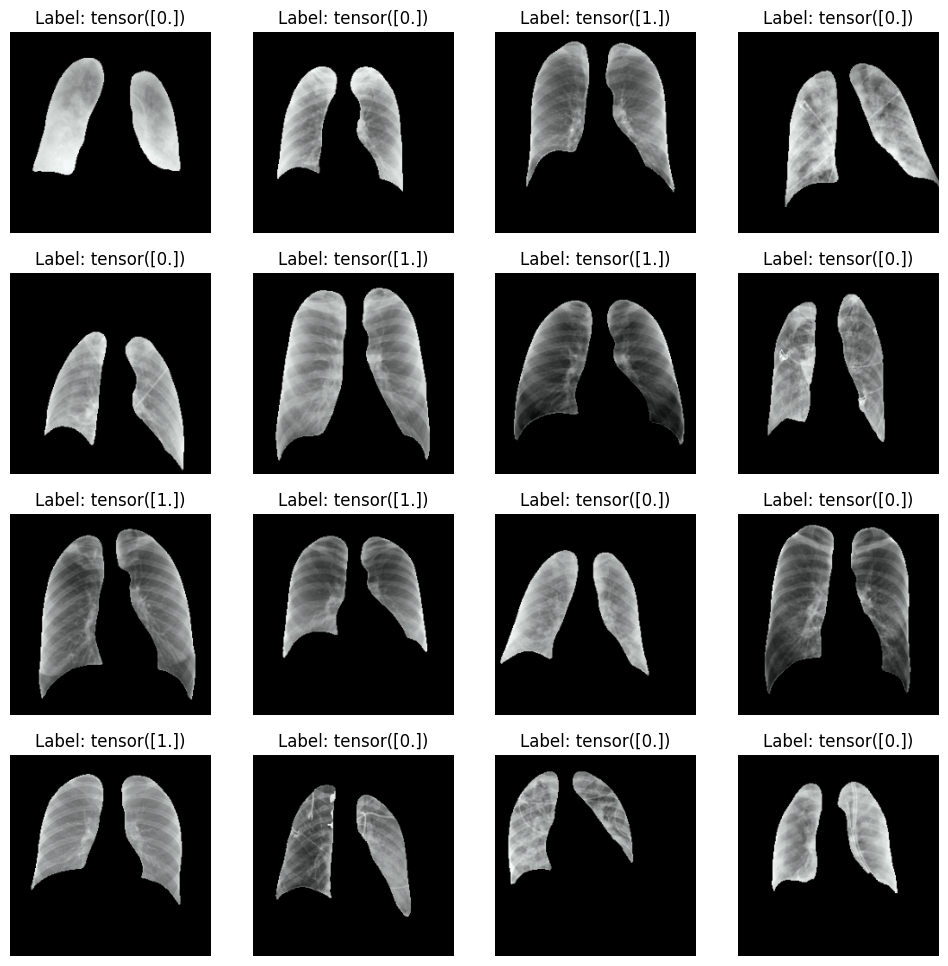

In [58]:
display_images_grid(imgs, ls)

In [61]:
def save_model_and_logs(model, loss_values, accuracies, val_loss_values, save_path):
    # Create the logs folder if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Save the model
    model_path = os.path.join(save_path, 'model.pt')
    torch.save(model.state_dict(), model_path)

    # Save the loss values and accuracies as numpy arrays
    logs_path = os.path.join(save_path, 'logs.npy')
    np.save(logs_path, {'loss_values': np.array(loss_values), 'accuracies': np.array(accuracies), "val_losses": np.array(val_loss_values)})

    print('Model and logs saved successfully.')


Calculating val loss
epoch 4,800 step and val loss is 0.4898057558592866 accuracy is 0.7762599224663098
Model and logs saved successfully.
epoch 4,800 step and val loss is tensor(0.5887, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


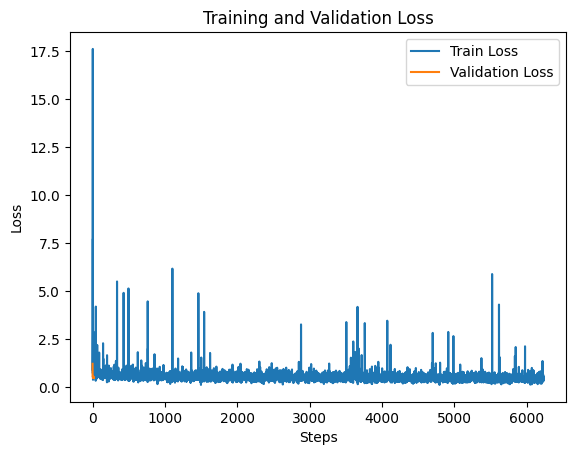

epoch 4,801 step and loss is tensor(0.4262, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
epoch 4,802 step and loss is tensor(0.2168, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
epoch 4,803 step and loss is tensor(0.3577, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
epoch 4,804 step and loss is tensor(0.3741, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
epoch 4,805 step and loss is tensor(0.2606, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
epoch 4,806 step and loss is tensor(0.5544, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
epoch 4,807 step and loss is tensor(0.6236, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
epoch 4,808 step and loss is tensor(0.2750, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
epoch 4,809 step and loss is tensor(0.4013, device='cuda:0',
   

In [ ]:
from IPython.display import clear_output

# Define the loss function
criterion = torch.nn.BCEWithLogitsLoss()

# Define the number of steps to plot the loss graph
plot_interval = 25

# Initialize an empty list to store the loss values
loss_values = []

val_loss_values = []

epoch_t_losses = []

accuracies = []

# Function to calculate validation loss
def calculate_validation_loss(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            # Calculate accuracy
            predicted_labels = torch.round(torch.sigmoid(outputs))
            correct_predictions += (predicted_labels == labels).sum().item()

    accuracy = correct_predictions / total_samples
    validation_loss = total_loss / total_samples

    return validation_loss, accuracy

# Training loop
for i in range(50):
  for step, (inputs, labels) in enumerate(train_loader):
      # Move inputs and labels to the device
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Perform forward pass
      outputs = new_model(inputs)

      # Calculate the loss
      loss = criterion(outputs, labels)

      print('epoch ' + str(i) + ',' +str(step) + " step and loss is " + str(loss))

      # Store the loss value
      loss_values.append(loss.item())

      # Perform backward pass and update the model parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Save validation loss every 25 steps
      if step % 400 == 0:
          clear_output(wait=True)
          print('Calculating val loss')
          val_loss, acc = calculate_validation_loss(new_model, val_loader, criterion)
          val_loss_values.append(val_loss)
          epoch_t_losses.append(loss.item())
          accuracies.append(acc)
          print('epoch ' + str(i) + ',' + str(step) + " step and val loss is " + str(val_loss) + " accuracy is " + str(acc))
          save_model_and_logs(new_model, loss_values, accuracies, val_loss_values, './logs_11/')

      # Plot the loss graph every 25 steps
      if (step) % 200 == 0:
          print('epoch ' + str(i) + ',' + str(step) + " step and val loss is " + str(loss))
          plt.plot(loss_values, label='Train Loss')
          plt.plot(val_loss_values, label='Validation Loss')
          plt.xlabel('Steps')
          plt.ylabel('Loss')
          plt.title('Training and Validation Loss')
          plt.legend()
          plt.show()